In [2]:
import numpy as np

data = np.load("atm_state_and_history.npz")

u      = data["u"]
w      = data["w"]
theta = data["theta"]
theta0 = data["theta0"]

snap_u  = data["snap_u"]
snap_w  = data["snap_w"]
snap_th = data["snap_th"]
snap_t  = data["snap_t"]

X = data["X"]
Z = data["Z"]

print("Loaded fields:", u.shape, w.shape, theta.shape)


Loaded fields: (40, 200) (40, 200) (40, 200)


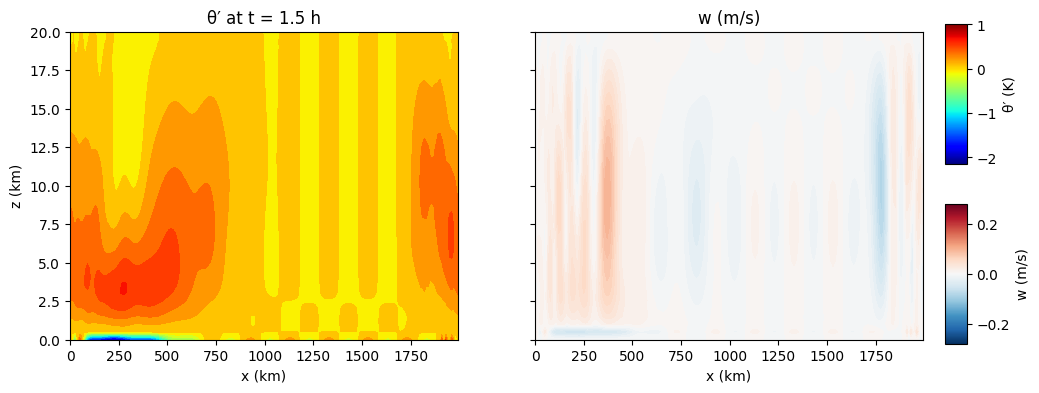

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ============================================================
# Plot one snapshot from loaded data (sanity check)
# ============================================================

# ------------------------
# choose snapshot index
# ------------------------
i = 3   # 0 = IC, 1 = first saved hour, etc.

# ------------------------
# coordinates
# ------------------------
X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------
# select fields
# ------------------------
if i == 0:
    theta_i = theta0
    w_i = np.zeros_like(theta0)
    hour = 0.0
else:
    theta_i = snap_th[i-1]
    w_i = snap_w[i-1]
    hour = snap_t[i-1] / 3600.0

theta_p = theta_i - theta0

# ------------------------
# global limits (same logic as before)
# ------------------------
thp_all = np.concatenate([(th - theta0).ravel() for th in [theta0] + list(snap_th)])
w_all   = np.concatenate([w.ravel() for w in [np.zeros_like(snap_w[0])] + list(snap_w)])

norm_th = Normalize(vmin=thp_all.min(), vmax=thp_all.max())
norm_w  = Normalize(vmin=-np.max(np.abs(w_all)), vmax=np.max(np.abs(w_all)))

# ------------------------
# figure
# ------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 4),
    sharex=True,
    sharey=True
)

# θ′
axes[0].contourf(
    X_km, Z_km, theta_p,
    levels=21,
    cmap="jet",
    norm=norm_th
)
axes[0].set_title("θ′ (IC)" if i == 0 else f"θ′ at t = {hour:.1f} h")
axes[0].set_xlabel("x (km)")
axes[0].set_ylabel("z (km)")

# w
axes[1].contourf(
    X_km, Z_km, w_i,
    levels=21,
    cmap="RdBu_r",
    norm=norm_w
)
axes[1].set_title("w (IC)" if i == 0 else "w (m/s)")
axes[1].set_xlabel("x (km)")

# ------------------------
# colorbars
# ------------------------
sm_th = ScalarMappable(norm=norm_th, cmap="jet")
sm_th.set_array([])

sm_w = ScalarMappable(norm=norm_w, cmap="RdBu_r")
sm_w.set_array([])

cax_th = fig.add_axes([0.92, 0.55, 0.02, 0.35])
cb_th = fig.colorbar(sm_th, cax=cax_th)
cb_th.set_label("θ′ (K)")

cax_w = fig.add_axes([0.92, 0.10, 0.02, 0.35])
cb_w = fig.colorbar(sm_w, cax=cax_w)
cb_w.set_label("w (m/s)")

plt.show()

✔ Created 2 synthetic radiosondes at t = 2.5 h
  Sonde 1: x ≈ 300.0 km (ix=30) | sigma_theta=0.02 K
  Sonde 2: x ≈ 800.0 km (ix=80) | sigma_theta=0.02 K


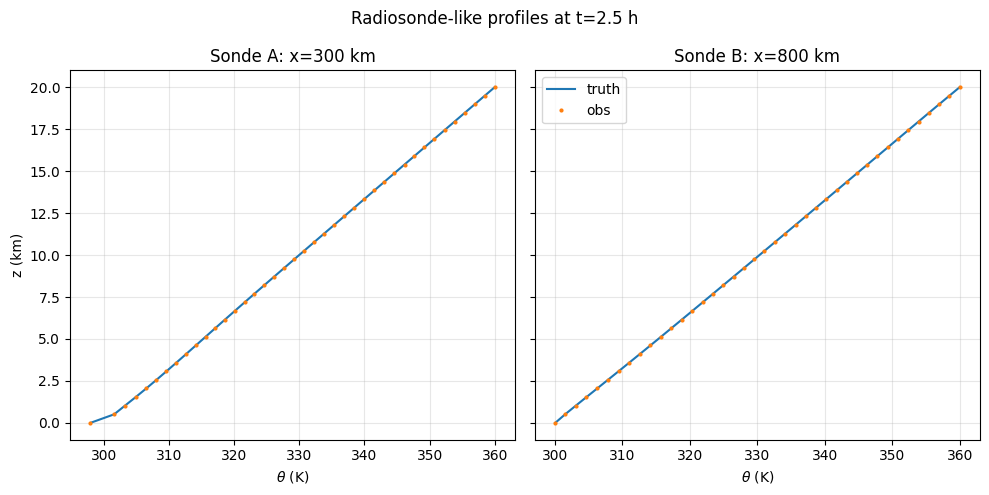

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Synthetic radiosonde observations at two x-locations
# ============================================================

# -------------------------
# 1) Choose analysis time
# -------------------------
i = 5  # 0 = IC, 1 = first saved hour, ... (same convention as before)

if i == 0:
    theta_true = theta0.copy()
    u_true = np.zeros_like(theta0)  # if you didn't store u, ignore u below
    t_hours = 0.0
else:
    theta_true = snap_th[i-1]
    t_hours = snap_t[i-1] / 3600.0
    # if you also saved/loaded snap_u, uncomment next line:
    # u_true = snap_u[i-1]

# vertical coordinate (meters + km)
z_m  = Z[:, 0].copy()
z_km = z_m / 1e3

# -------------------------
# 2) Define 2 sonde locations (in km)
# -------------------------
sonde_x_km = [300.0, 800.0]  # choose any two positions in [0, Lx_km)
x_km = X[0, :] / 1e3

# convert to nearest grid indices
sonde_ix = [int(np.argmin(np.abs(x_km - xx))) for xx in sonde_x_km]

# -------------------------
# 3) Observation operator: extract vertical columns at those x indices
# -------------------------
def H_sonde_theta(theta_field, ix):
    """Return vertical profile theta(z) at fixed x-index ix."""
    return theta_field[:, ix].copy()

# (optional) for wind:
# def H_sonde_u(u_field, ix):
#     return u_field[:, ix].copy()

# -------------------------
# 4) Create noisy observations
# -------------------------
rng = np.random.default_rng(42)

sigma_theta = 0.02   # K (typical radiosonde order, toy level)
# sigma_u = 0.5     # m/s (optional)

obs = []
for ix in sonde_ix:
    y_theta_true = H_sonde_theta(theta_true, ix)
    y_theta_obs  = y_theta_true + rng.normal(0.0, sigma_theta, size=y_theta_true.shape)

    obs.append({
        "ix": ix,
        "x_km": float(x_km[ix]),
        "z_m": z_m,
        "theta_true": y_theta_true,
        "theta_obs": y_theta_obs,
        "sigma_theta": sigma_theta
    })

print(f"✔ Created 2 synthetic radiosondes at t = {t_hours:.1f} h")
for k,o in enumerate(obs, start=1):
    print(f"  Sonde {k}: x ≈ {o['x_km']:.1f} km (ix={o['ix']}) | sigma_theta={o['sigma_theta']} K")

# -------------------------
# 5) Quick plot: truth vs observations
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for ax, o, title in zip(axes, obs, ["Sonde A", "Sonde B"]):
    ax.plot(o["theta_true"], z_km, label="truth")
    ax.plot(o["theta_obs"],  z_km, ".", label="obs", markersize=4)
    ax.set_title(f"{title}: x={o['x_km']:.0f} km")
    ax.set_xlabel(r"$\theta$ (K)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("z (km)")
axes[1].legend(loc="best")
plt.suptitle(f"Radiosonde-like profiles at t={t_hours:.1f} h")
plt.tight_layout()
plt.show()


In [6]:
# ============================================================
# Save radiosonde observations to NPZ
# ============================================================

# stack profiles: shape = (n_sondes, n_z)
theta_true_all = np.stack([o["theta_true"] for o in obs], axis=0)
theta_obs_all  = np.stack([o["theta_obs"]  for o in obs], axis=0)

# metadata
sonde_ix_all   = np.array([o["ix"] for o in obs], dtype=int)
sonde_x_km_all = np.array([o["x_km"] for o in obs], dtype=float)

# (same z for all sondes)
z_m_all        = obs[0]["z_m"]
sigma_theta   = obs[0]["sigma_theta"]

# time info
t_hours_obs   = float(t_hours)
itime_index   = int(i)

np.savez(
    "radiosonde_obs_t{:03d}.npz".format(itime_index),
    theta_true = theta_true_all,
    theta_obs  = theta_obs_all,
    z_m        = z_m_all,
    sonde_ix   = sonde_ix_all,
    sonde_x_km = sonde_x_km_all,
    sigma_theta = sigma_theta,
    t_hours    = t_hours_obs,
    itime      = itime_index
)

print("✔ Saved radiosonde observations:",
      f"radiosonde_obs_t{itime_index:03d}.npz")

✔ Saved radiosonde observations: radiosonde_obs_t005.npz


/tmp/ipykernel_22796/689646850.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


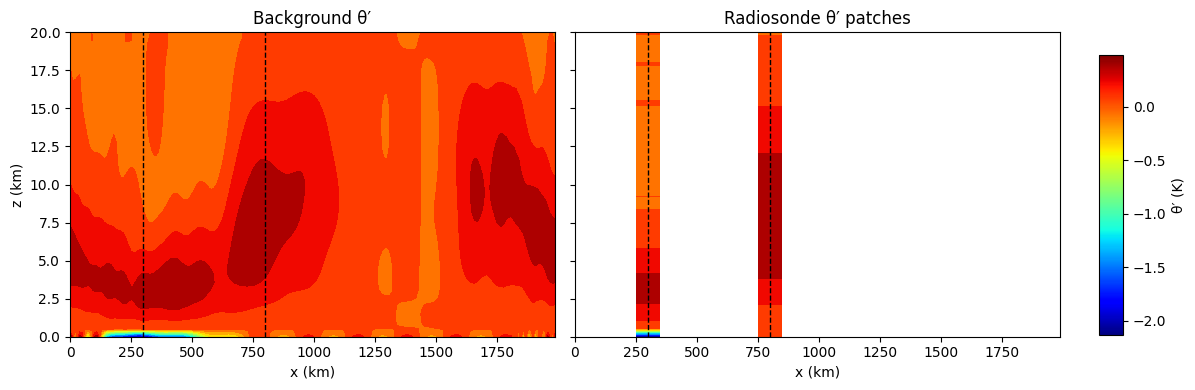

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ============================================================
# Background θ′ vs radiosonde θ′ patches (finite width)
# ============================================================

X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------------------------------------------
# Background field
# ------------------------------------------------------------
theta_bg = theta_true.copy()
theta_p_bg = theta_bg - theta0

# ------------------------------------------------------------
# Radiosonde-only field (NaN everywhere initially)
# ------------------------------------------------------------
theta_obs_only = np.full_like(theta_bg, np.nan)

# width of radiosonde "influence" in grid points
half_width = 5   # +/- 2 grid points → visible patch

for o in obs:
    ix = o["ix"]
    ix0 = max(0, ix - half_width)
    ix1 = min(theta_bg.shape[1], ix + half_width + 1)

    # fill a small x-band with the observed vertical profile
    theta_obs_only[:, ix0:ix1] = o["theta_obs"][:, None]

theta_p_obs = theta_obs_only - theta0   # NaN-safe

# ------------------------------------------------------------
# Color limits (shared, robust)
# ------------------------------------------------------------
thp_all = np.concatenate([
    theta_p_bg[~np.isnan(theta_p_bg)],
    theta_p_obs[~np.isnan(theta_p_obs)]
])

norm_th = Normalize(vmin=thp_all.min(), vmax=thp_all.max())

# ------------------------------------------------------------
# Colormap with NaNs as white
# ------------------------------------------------------------
cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="white")

# ------------------------------------------------------------
# Figure
# ------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    sharex=True,
    sharey=True
)

# LEFT: background θ′
axes[0].contourf(
    X_km, Z_km, theta_p_bg,
    levels=21,
    cmap=cmap,
    norm=norm_th
)
axes[0].set_title("Background θ′")
axes[0].set_xlabel("x (km)")
axes[0].set_ylabel("z (km)")

# mark sonde centers
for o in obs:
    axes[0].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# RIGHT: radiosonde patches only
axes[1].contourf(
    X_km, Z_km, theta_p_obs,
    levels=21,
    cmap=cmap,
    norm=norm_th
)
axes[1].set_title("Radiosonde θ′ patches")
axes[1].set_xlabel("x (km)")

# mark sonde centers
for o in obs:
    axes[1].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# ------------------------------------------------------------
# Shared colorbar
# ------------------------------------------------------------
sm_th = ScalarMappable(norm=norm_th, cmap=cmap)
sm_th.set_array([])

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = fig.colorbar(sm_th, cax=cax)
cb.set_label("θ′ (K)")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [26]:
o["theta_obs"]

array([300.09872248, 301.56647323, 303.11557376, 304.71582469,
       306.30205097, 307.89269058, 309.49025947, 311.0553381 ,
       312.63500689, 314.18587104, 315.74654171, 317.30371881,
       318.80741458, 320.37173436, 321.90721502, 323.43989372,
       324.98120795, 326.54890912, 328.03239014, 329.59821505,
       331.07278306, 332.62577328, 334.16020282, 335.69163438,
       337.21566157, 338.73751532, 340.23372429, 341.74952096,
       343.29321172, 344.78892424, 346.28354616, 347.80250323,
       349.32287301, 350.86746877, 352.37707636, 353.9056712 ,
       355.40272648, 356.93704107, 358.47498956, 359.99381307])

In [28]:
for k, o in enumerate(obs, start=1):
    ix = o["ix"]
    bg_prof = theta_true[:, ix]
    diff = o["theta_obs"] - bg_prof
    print(
        f"Sonde {k}: x={o['x_km']:.1f} km (ix={ix}) | "
        f"diff: mean={diff.mean():+.3e} K, rms={np.sqrt(np.mean(diff**2)):.3e} K, "
        f"max={np.max(np.abs(diff)):.3e} K"
    )


Sonde 1: x=300.0 km (ix=30) | diff: mean=+7.653e-04 K, rms=1.633e-02 K, max=4.283e-02 K
Sonde 2: x=800.0 km (ix=80) | diff: mean=+2.635e-04 K, rms=1.441e-02 K, max=3.366e-02 K


Using a shifted background: 100.0 km (~10 grid points)
3D-Var setup: grid N=8000, obs m=80 (2 sondes × 40 levels)
Innovation stats: mean=+1.048e-02 K, rms=7.782e-02 K, max=3.810e-01 K
Increment stats: min=-3.123e-01 K, max=+3.552e-01 K, rms=3.810e-02 K


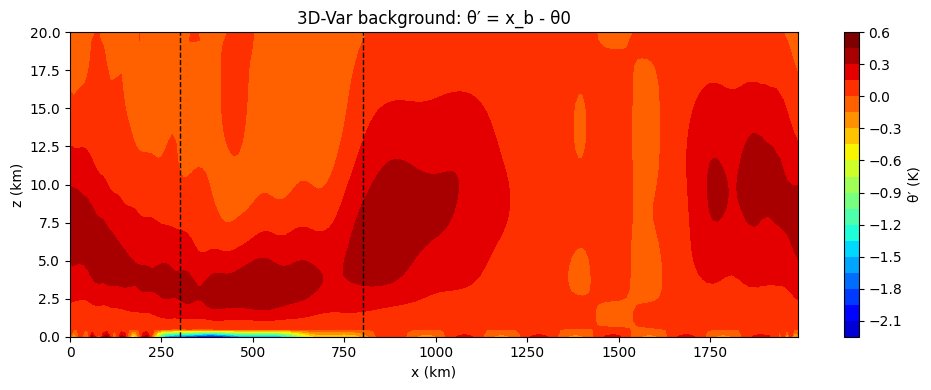

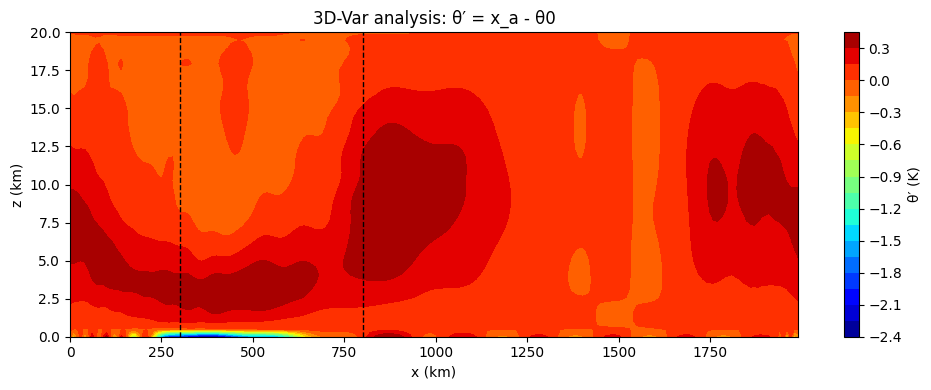

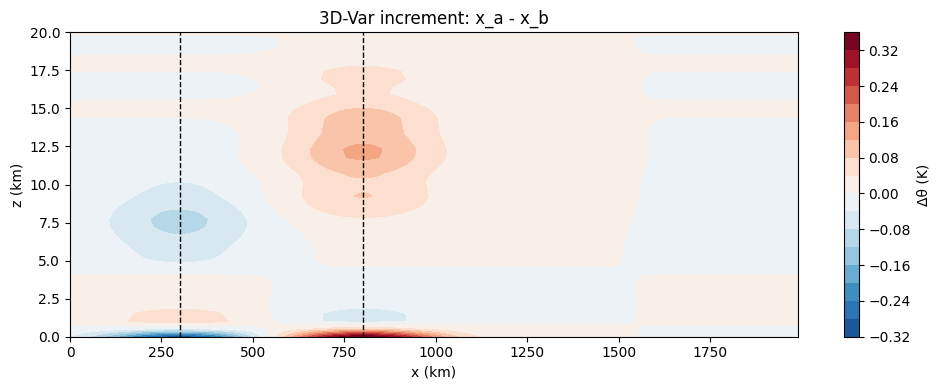

✔ Saved: atm_da_xb.png, atm_da_xa.png, atm_da_dx.png


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ============================================================
# 3D-Var (variational) assimilation for theta (single analysis time)
#
# Cost function:
#   J(x) = 1/2 (x - x_b)^T B^{-1} (x - x_b) + 1/2 (y - Hx)^T R^{-1} (y - Hx)
#
# Closed-form solution (equivalent to 3D-Var / OI / Kalman update with static B):
#   x_a = x_b + B H^T (H B H^T + R)^{-1} (y - H x_b)
#
# Here:
# - x is theta on the full (z,x) grid
# - H samples theta at radiosonde points (two columns, all nz levels)
# - B is Gaussian in space (periodic in x)
# ============================================================

# -------------------------
# Background state x_b
# -------------------------
shift_km = 100.0
dx_km = (X[0,1] - X[0,0]) / 1e3
ishift = int(round(shift_km / dx_km))
xb = np.roll(theta_true, shift=ishift, axis=1)
print(f"Using a shifted background: {shift_km:.1f} km (~{ishift} grid points)")

# coordinates
x = X[0, :].copy()   # meters, (nx,)
z = Z[:, 0].copy()   # meters, (nz,)

# -------------------------
# DA tunables
# -------------------------
sigma_b = 0.5     # K, background std
Lx = 150e3        # m, horizontal corr length
Lz = 1500.0       # m, vertical corr length

# -------------------------
# Build observation vector y, R, and obs locations for H
# obs: list of two sondes, each with:
#   o["ix"] (x index), o["x_km"] (x location), o["theta_obs"] (nz,), o["sigma_theta"]
# -------------------------
y_list = []
Rdiag_list = []
obs_locs = []  # list of (iz, ix)

for o in obs:
    ix = int(o["ix"])
    sig = float(o.get("sigma_theta", 0.02))
    prof = o["theta_obs"]
    assert prof.shape[0] == nz, "obs profile must have nz elements"

    for iz in range(nz):
        y_list.append(prof[iz])
        Rdiag_list.append(sig**2)
        obs_locs.append((iz, ix))

y = np.array(y_list)            # (m,)
Rdiag = np.array(Rdiag_list)    # (m,)
m = y.size

# -------------------------
# Compute innovation d = y - H x_b
# -------------------------
Hx_b = np.array([xb[iz, ix] for (iz, ix) in obs_locs])
d = y - Hx_b

print(f"3D-Var setup: grid N={nz*nx}, obs m={m} ({len(obs)} sondes × {nz} levels)")
print(f"Innovation stats: mean={d.mean():+.3e} K, rms={np.sqrt(np.mean(d**2)):.3e} K, max={np.max(np.abs(d)):.3e} K")

# -------------------------
# Helper: periodic distance in x
# -------------------------
dx_grid = x[1] - x[0]
Lx_domain = nx * dx_grid  # meters

def periodic_dx(x_arr, x0):
    """Return periodic distance |x - x0| on [0, Lx_domain)."""
    dx_raw = x_arr - x0
    dx_abs = np.abs(dx_raw)
    return np.minimum(dx_abs, Lx_domain - dx_abs)

# -------------------------
# Build S = H B H^T + R  (m x m)
# Since H selects gridpoints, (H B H^T)_{ij} = B(p_i, p_j) where p_i are obs points.
# B(p_i,p_j) = sigma_b^2 * exp(-0.5*((dx/Lx)^2 + (dz/Lz)^2))
# -------------------------
S = np.empty((m, m), dtype=np.float64)

# precompute obs coordinates
obs_x = np.array([x[ix] for (iz, ix) in obs_locs], dtype=np.float64)
obs_z = np.array([z[iz] for (iz, ix) in obs_locs], dtype=np.float64)

for i in range(m):
    dxi = periodic_dx(obs_x, obs_x[i]) / Lx     # (m,)
    dzi = (obs_z - obs_z[i]) / Lz               # (m,)
    S[i, :] = (sigma_b**2) * np.exp(-0.5 * (dxi*dxi + dzi*dzi))

# add R
S[np.diag_indices(m)] += Rdiag

# -------------------------
# Solve for alpha: (H B H^T + R) alpha = d
# then increment on grid: δx = B H^T alpha = Σ_j B(grid, obs_j) * alpha_j
# -------------------------
alpha = np.linalg.solve(S, d)

# compute δtheta on full grid
dtheta = np.zeros_like(xb, dtype=np.float64)

Xgrid = X  # (nz,nx)
Zgrid = Z  # (nz,nx)

for j, ((iz_j, ix_j), aj) in enumerate(zip(obs_locs, alpha)):
    xj = x[ix_j]
    zj = z[iz_j]

    dxp = periodic_dx(x, xj)[None, :] / Lx                 # (1,nx)
    dzp = (z[:, None] - zj) / Lz                            # (nz,1)
    wloc = np.exp(-0.5 * (dxp*dxp + dzp*dzp))               # (nz,nx)

    dtheta += (sigma_b**2) * wloc * aj

xa = xb + dtheta

print(f"Increment stats: min={dtheta.min():+.3e} K, max={dtheta.max():+.3e} K, rms={np.sqrt(np.mean(dtheta**2)):.3e} K")

# ============================================================
# Visualization: x_b, x_a, x_a-x_b stacked (3 rows)
# and save as separate files:
#   atm_da_xb.png, atm_da_xa.png, atm_da_dx.png
# ============================================================

X_km = X / 1e3
Z_km = Z / 1e3

# Use θ′ for xb and xa (same scaling)
thp_b = xb - theta0
thp_a = xa - theta0
dth   = xa - xb

# shared limits for xb/xa panels
vmin = min(thp_b.min(), thp_a.min())
vmax = max(thp_b.max(), thp_a.max())
norm_thp = Normalize(vmin=vmin, vmax=vmax)

# increment limits (symmetric)
dmax = np.max(np.abs(dth))
norm_d = Normalize(vmin=-dmax, vmax=dmax)

# --- Figure 1: xb ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cf = ax.contourf(X_km, Z_km, thp_b, levels=21, cmap="jet", norm=norm_thp)
for o in obs:
    ax.axvline(o["x_km"], color="k", linestyle="--", linewidth=1)
ax.set_title("3D-Var background: θ′ = x_b - θ0")
ax.set_xlabel("x (km)")
ax.set_ylabel("z (km)")
plt.colorbar(cf, ax=ax, label="θ′ (K)")
plt.tight_layout()
plt.savefig("atm_da_xb.png", dpi=150)
plt.show()
plt.close(fig)

# --- Figure 2: xa ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cf = ax.contourf(X_km, Z_km, thp_a, levels=21, cmap="jet", norm=norm_thp)
for o in obs:
    ax.axvline(o["x_km"], color="k", linestyle="--", linewidth=1)
ax.set_title("3D-Var analysis: θ′ = x_a - θ0")
ax.set_xlabel("x (km)")
ax.set_ylabel("z (km)")
plt.colorbar(cf, ax=ax, label="θ′ (K)")
plt.tight_layout()
plt.savefig("atm_da_xa.png", dpi=150)
plt.show()
plt.close(fig)

# --- Figure 3: increment xa-xb ---
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cf = ax.contourf(X_km, Z_km, dth, levels=21, cmap="RdBu_r", norm=norm_d)
for o in obs:
    ax.axvline(o["x_km"], color="k", linestyle="--", linewidth=1)
ax.set_title("3D-Var increment: x_a - x_b")
ax.set_xlabel("x (km)")
ax.set_ylabel("z (km)")
plt.colorbar(cf, ax=ax, label="Δθ (K)")
plt.tight_layout()
plt.savefig("atm_da_dx.png", dpi=150)
plt.show()
plt.close(fig)

print("✔ Saved: atm_da_xb.png, atm_da_xa.png, atm_da_dx.png")


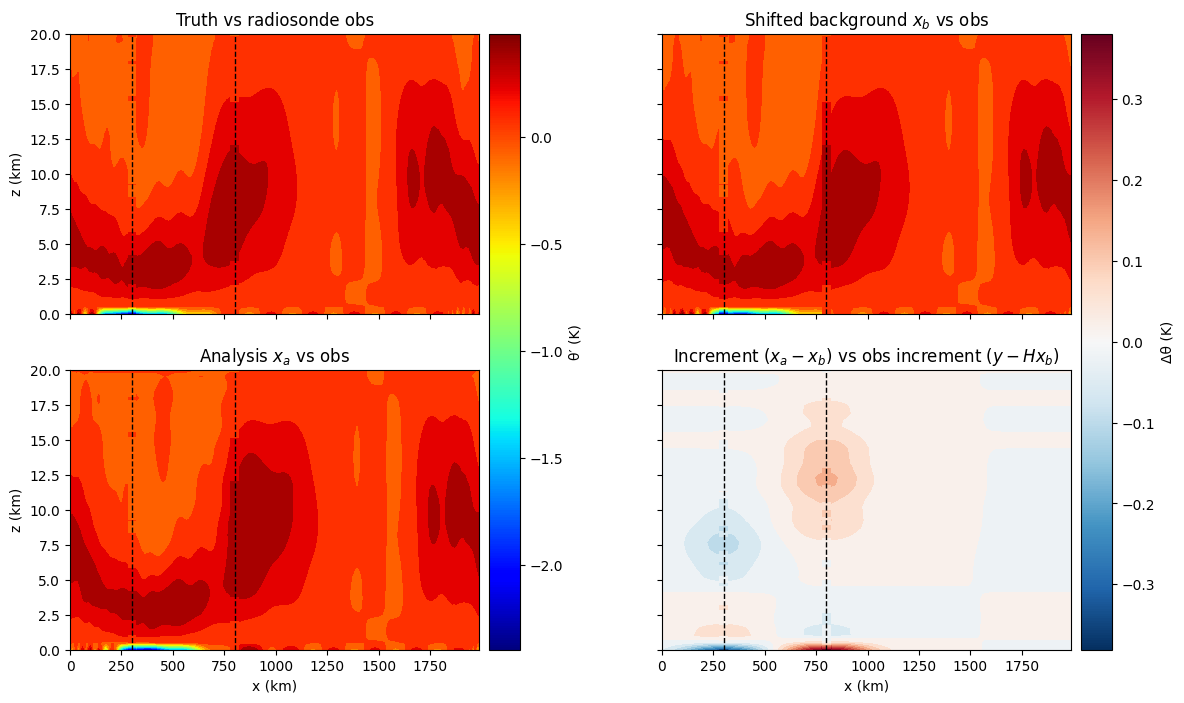

✔ Saved: atm_da_diagnostic_2x2.png


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ============================================================
# 2x2 DA diagnostic:
# Row 1: truth vs obs | background vs obs
# Row 2: analysis vs obs | increment vs obs increment
# ============================================================

X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------------------------------------------
# Fields (θ′)
# ------------------------------------------------------------
thp_true = theta_true - theta0
thp_bg   = xb - theta0
thp_an   = xa - theta0

# increments
dth_model = xa - xb   # xa - xb

# ------------------------------------------------------------
# Build obs patch fields
# ------------------------------------------------------------
thp_obs_patch   = np.full_like(thp_true, np.nan)
innov_patch     = np.full_like(thp_true, np.nan)

patch_halfwidth_km = 20.0
dx_km = X_km[0, 1] - X_km[0, 0]
patch_halfwidth_ix = int(round(patch_halfwidth_km / dx_km))

for o in obs:
    ix0 = int(o["ix"])

    # θ′ obs
    thp_obs = o["theta_obs"] - theta0[:, ix0]

    # obs increment y - Hxb
    innov = o["theta_obs"] - xb[:, ix0]

    for dix in range(-patch_halfwidth_ix, patch_halfwidth_ix + 1):
        ix = (ix0 + dix) % thp_true.shape[1]
        thp_obs_patch[:, ix] = thp_obs
        innov_patch[:, ix]  = innov

# ------------------------------------------------------------
# Color scaling
# ------------------------------------------------------------
# θ′ scaling (row 1 + analysis)
vmin_th = min(np.nanmin(thp_true), np.nanmin(thp_bg), np.nanmin(thp_an))
vmax_th = max(np.nanmax(thp_true), np.nanmax(thp_bg), np.nanmax(thp_an))
norm_th = Normalize(vmin=vmin_th, vmax=vmax_th)

# increment scaling (row 2 right)
dmax = max(np.nanmax(np.abs(dth_model)), np.nanmax(np.abs(innov_patch)))
norm_d = Normalize(vmin=-dmax, vmax=dmax)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(14, 8),
    sharex=True,
    sharey=True
)

# ===== Row 1 =====
# Truth vs obs
axes[0, 0].contourf(X_km, Z_km, thp_true, levels=21, cmap="jet", norm=norm_th)
axes[0, 0].contourf(X_km, Z_km, thp_obs_patch, levels=21, cmap="jet", norm=norm_th)
axes[0, 0].set_title("Truth vs radiosonde obs")
axes[0, 0].set_ylabel("z (km)")
for o in obs:
    axes[0, 0].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# Shifted background vs obs
axes[0, 1].contourf(X_km, Z_km, thp_bg, levels=21, cmap="jet", norm=norm_th)
axes[0, 1].contourf(X_km, Z_km, thp_obs_patch, levels=21, cmap="jet", norm=norm_th)
axes[0, 1].set_title("Shifted background $x_b$ vs obs")
for o in obs:
    axes[0, 1].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# ===== Row 2 =====
# Analysis vs obs
axes[1, 0].contourf(X_km, Z_km, thp_an, levels=21, cmap="jet", norm=norm_th)
axes[1, 0].contourf(X_km, Z_km, thp_obs_patch, levels=21, cmap="jet", norm=norm_th)
axes[1, 0].set_title("Analysis $x_a$ vs obs")
axes[1, 0].set_xlabel("x (km)")
axes[1, 0].set_ylabel("z (km)")
for o in obs:
    axes[1, 0].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# Increment vs obs increment
axes[1, 1].contourf(X_km, Z_km, dth_model, levels=21, cmap="RdBu_r", norm=norm_d)
axes[1, 1].contourf(X_km, Z_km, innov_patch, levels=21, cmap="RdBu_r", norm=norm_d)
axes[1, 1].set_title("Increment $(x_a-x_b)$ vs obs increment $(y-Hx_b)$")
axes[1, 1].set_xlabel("x (km)")
for o in obs:
    axes[1, 1].axvline(o["x_km"], color="k", linestyle="--", linewidth=1)

# ------------------------------------------------------------
# Colorbars
# ------------------------------------------------------------
sm_th = ScalarMappable(norm=norm_th, cmap="jet")
sm_th.set_array([])
cbar1 = plt.colorbar(sm_th, ax=axes[:, 0].ravel().tolist(), pad=0.02)
cbar1.set_label("θ′ (K)")

sm_d = ScalarMappable(norm=norm_d, cmap="RdBu_r")
sm_d.set_array([])
cbar2 = plt.colorbar(sm_d, ax=axes[:, 1].ravel().tolist(), pad=0.02)
cbar2.set_label("Δθ (K)")

plt.savefig("atm_da_diagnostic_2x2.png", dpi=150)
plt.show()

print("✔ Saved: atm_da_diagnostic_2x2.png")
